# OWASP Benchmark Tool Analysis

## Scorecard Metrics Extraction and Visualization

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from bs4 import BeautifulSoup
import glob
import os
import json
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

### Data Extraction Functions

In [2]:
tool_types = {'CodeQL':'SAST', 'Semgrep':'SAST', 'SonarQube':'SAST', 'PMD':'SAST', 'SpotBugs':'SAST', 'Horusec': 'SAST', 'Insider': 'SAST',\
              'Qwiet': 'ML', 'SnykCode': 'ML',
              'Corgea': 'AI', 'Qodo': 'AI', 'Endor': 'AI',
              'GPT': 'LLM', 'Claude': 'LLM', 'DeepSeek': 'LLM', 'Granite': 'LLM', 'Llama': 'LLM', 'Qwen': 'LLM', 'Gemini': 'LLM'}

In [3]:
def parse_tool_scorecard(html_file):
    """
    Parse individual tool scorecard HTML to extract metrics.
    Returns DataFrame with vulnerability-specific metrics for the tool.
    """

    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # extract tool name from title or heading
    title = soup.find('h3')
    if title:
        tool_name = title.text.replace('OWASP Benchmark Scorecard for ', '').replace(' (SAST)', '').strip()
    else:
        tool_name = Path(html_file).stem
    
    # find results table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        # check if this is the detailed results table
        if 'Category' in headers and 'CWE #' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]: # skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 9: # ensure data
                    if cells[0] not in ['Totals', 'Overall Results*']:
                        rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Category', 'CWE', 'TP', 'FN', 'TN', 'FP', 'Total', 'TPR', 'FPR', 'Score'])
                df['Tool'] = tool_name
                
                # convert numeric columns
                numeric_cols = ['TP', 'FN', 'TN', 'FP', 'Total']
                for col in numeric_cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                #convert percentage columns
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

def parse_vulnerability_scorecard(html_file):
    """
    Parse vulnerability-specific scorecard to extract all tools' performance on that vulnerability.
    """

    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # extract vulnerability name
    title = soup.find('h3')
    if title:
        vuln_name = title.text.replace('OWASP Benchmark Scorecard for ', '').strip()
    else:
        vuln_name = Path(html_file).stem
    
    # find the detailed results table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        if 'Tool' in headers and 'Type' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]:
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 9:
                    rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Tool', 'Type', 'TP', 'FN', 'TN', 'FP', 'Total', 'TPR', 'FPR', 'Score'])
                df['Vulnerability'] = vuln_name
                
                # convert numeric columns
                numeric_cols = ['TP', 'FN', 'TN', 'FP', 'Total']
                for col in numeric_cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # convert percentage columns
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

def parse_summary_scorecard(html_file):
    """
    Parse the summary scorecard to get overall tool scores.
    """
    
    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # find summary table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        if 'Tool' in headers and 'Type' in headers and 'Score*' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]:  # Skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 4:
                    rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Tool', 'Type', 'TPR', 'FPR', 'Score'])
                
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

### Load All Scorecard Data

In [4]:
scorecard_dir = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/BenchmarkJava/scorecard'
to_save = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/BenchmarkJava/scorecard/outputs/'
os.makedirs(to_save, exist_ok=True)

In [5]:
# find all scorecard HTML files
tool_scorecards = glob.glob(os.path.join(scorecard_dir, '*CodeQL*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Semgrep*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Snyk*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SonarQube*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SpotBugs*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Horusec*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Insider*.html'))

vuln_scorecards = glob.glob(os.path.join(scorecard_dir, '*Command_Injection*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SQL_Injection*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*XSS*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Path_Traversal*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*LDAP*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Weak_*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Insecure_Cookie*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Trust_Boundary*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*XPath*.html'))

summary_file = os.path.join(scorecard_dir, 'Scorecard_Home.html')

print(f"Found {len(tool_scorecards)} tool-specific scorecards")
print(f"Found {len(vuln_scorecards)} vulnerability-specific scorecards")
print(f"Summary file exists: {os.path.exists(summary_file)}")

Found 7 tool-specific scorecards
Found 11 vulnerability-specific scorecards
Summary file exists: True


In [6]:
# parse all tool scorecards
tool_data = []
for file in tool_scorecards:
    df = parse_tool_scorecard(file)
    if df is not None:
        tool_data.append(df)

if tool_data:
    df_tools = pd.concat(tool_data, ignore_index=True)
    print(f"Loaded data for {df_tools['Tool'].nunique()} tools across {df_tools['Category'].nunique()} vulnerability categories")
    print(f"Total records: {len(df_tools)}")
else:
    print("No tool data loaded")

Loaded data for 7 tools across 11 vulnerability categories
Total records: 77


In [7]:
# parse all vulnerability scorecards
vuln_data = []
for file in vuln_scorecards:
    df = parse_vulnerability_scorecard(file)
    if df is not None:
        vuln_data.append(df)

if vuln_data:
    df_vulns = pd.concat(vuln_data, ignore_index=True)
    print(f"Loaded vulnerability data for {df_vulns['Vulnerability'].nunique()} vulnerabilities")
else:
    print("No vulnerability data loaded")

Loaded vulnerability data for 11 vulnerabilities


In [8]:
# parse summary
if os.path.exists(summary_file):
    df_summary = parse_summary_scorecard(summary_file)
    if df_summary is not None:
        print(f"Loaded summary data for {len(df_summary)} tools")
        display(df_summary)
else:
    print("Summary file not found")

Loaded summary data for 7 tools


,Tool,Type,TPR,FPR,Score
0,CodeQL v2.23.6_w1.10.0rules,SAST,100.00,37.99,62.01
1,Horusec vv2.8.0,SAST,31.13,23.13,8.00
2,Insider,SAST,23.85,23.29,0.56
3,Semgrep v1.143.1,SAST,82.58,47.48,35.10
4,SnykCode v1.1301.0,SAST,97.18,25.16,72.02
5,SonarQube,SAST,9.09,2.12,6.97
6,SpotBugs v4.9.8,SAST,97.18,53.44,43.75


### Load Results from Other Tools

In [9]:
def load_framework_results(json_file, tool_name):
    """
    Load analysis results from our framework's JSON format and convert to scorecard format.
    """
    
    # Category mapping from abbreviated names to full scorecard names
    category_map = {
        'cmdi': ('Command Injection', '78'),
        'crypto': ('Weak Encryption Algorithm', '327'),
        'hash': ('Weak Hashing Algorithm', '328'),
        'ldapi': ('LDAP Injection', '90'),
        'pathtraver': ('Path Traversal', '22'),
        'securecookie': ('Insecure Cookie', '614'),
        'sqli': ('SQL Injection', '89'),
        'trustbound': ('Trust Boundary', '501'),
        'weakrand': ('Weak Randomness', '330'),
        'xpathi': ('XPath Injection', '643'),
        'xss': ('XSS (Cross-Site Scripting)', '79')
    }
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    rows = []
    
    for short_name, metrics in data['by_category'].items():
        if short_name not in category_map:
            continue

        category_name, cwe = category_map[short_name]

        # Extract metrics
        total = metrics['total_tests']
        expected = metrics['vulnerable_tests']
        non_category_cases = metrics['safe_tests']
        tp = metrics['tp']
        fp = metrics['fp']
        fn = metrics['fn']
        tn = metrics['tn']

        # Calculate rates
        tpr = (tp / expected * 100) if expected > 0 else 0.0
        fpr = (fp / non_category_cases * 100) if non_category_cases > 0 else 0.0
        score = tpr - fpr

        rows.append({
            'Category': category_name,
            'CWE': cwe,
            'TP': tp,
            'FN': fn,
            'TN': tn,
            'FP': fp,
            'Total': total,
            'TPR': round(tpr, 2),
            'FPR': round(fpr, 2),
            'Score': round(score, 2),
            'Tool': tool_name
        })

    return pd.DataFrame(rows)

In [10]:
qwiet_file = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/tool_analysis/reports/qwiet_analysis.json'
corgea_file = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/tool_analysis/reports/corgea_analysis.json'

In [11]:
additional_tools = []

In [12]:
# Load Qwiet
if os.path.exists(qwiet_file):
    df_qwiet = load_framework_results(qwiet_file, 'Qwiet')
    additional_tools.append(df_qwiet)
    print(f"Loaded Qwiet data: {len(df_qwiet)} vulnerability categories")
else:
    print(f"Qwiet file not found: {qwiet_file}")

Loaded Qwiet data: 4 vulnerability categories


In [13]:
# Load Corgea
if os.path.exists(corgea_file):
    df_corgea = load_framework_results(corgea_file, 'Corgea')
    additional_tools.append(df_corgea)
    print(f"Loaded Corgea data: {len(df_corgea)} vulnerability categories")
else:
    print(f"Corgea file not found: {corgea_file}")

Loaded Corgea data: 11 vulnerability categories


In [14]:
# Merge with existing tool data
if additional_tools and 'df_tools' in locals():
    df_tools_original = df_tools.copy()
    df_tools = pd.concat([df_tools_original] + additional_tools, ignore_index=True)
    df_tools['Tool'] = df_tools['Tool'].apply(lambda x: x.split()[0] if ' ' in x else x)
    df_tools['Type'] = df_tools['Tool'].apply(lambda tool: tool_types.get(tool, 'Unknown'))
    
    print(f"Combined dataset now includes {df_tools['Tool'].nunique()} tools")
    print(f"Tools: {', '.join(df_tools['Tool'].unique())}")
elif additional_tools:
    df_tools = pd.concat(additional_tools, ignore_index=True)
    print(f"Created dataset with {df_tools['Tool'].nunique()} tools from framework")

Combined dataset now includes 9 tools
Tools: CodeQL, Semgrep, SnykCode, SonarQube, SpotBugs, Horusec, Insider, Qwiet, Corgea


### Load Results from LLMs

In [15]:
def expand_category_names(short_map: dict) -> dict:
    """Convert short category names to full descriptive names"""
    
    # Mapping from short names to full names
    name_expansion = {
        'pathtraver': 'Path Traversal',
        'hash': 'Weak Hashing Algorithm',
        'trustbound': 'Trust Boundary',
        'crypto': 'Weak Encryption Algorithm',
        'cmdi': 'Command Injection',
        'sqli': 'SQL Injection',
        'weakrand': 'Weak Randomness',
        'ldapi': 'LDAP Injection',
        'xss': 'XSS (Cross-Site Scripting)',
        'securecookie': 'Insecure Cookie',
        'xpathi': 'XPath Injection'
    }
    
    # Create new map with full names
    full_name_map = {}
    for cwe, short_name in short_map.items():
        full_name = name_expansion.get(short_name, short_name) # fallback to short_name if not found
        full_name_map[cwe] = full_name
    
    return full_name_map

short_map = {
    'CWE-22': 'pathtraver', 
    'CWE-328': 'hash', 
    'CWE-501': 'trustbound', 
    'CWE-327': 'crypto', 
    'CWE-78': 'cmdi', 
    'CWE-89': 'sqli', 
    'CWE-330': 'weakrand', 
    'CWE-90': 'ldapi', 
    'CWE-79': 'xss', 
    'CWE-614': 'securecookie', 
    'CWE-643': 'xpathi'
}

full_map = expand_category_names(short_map)
pprint(full_map)

{'CWE-22': 'Path Traversal',
 'CWE-327': 'Weak Encryption Algorithm',
 'CWE-328': 'Weak Hashing Algorithm',
 'CWE-330': 'Weak Randomness',
 'CWE-501': 'Trust Boundary',
 'CWE-614': 'Insecure Cookie',
 'CWE-643': 'XPath Injection',
 'CWE-78': 'Command Injection',
 'CWE-79': 'XSS (Cross-Site Scripting)',
 'CWE-89': 'SQL Injection',
 'CWE-90': 'LDAP Injection'}


In [16]:
RESULTS_DIR = Path("results/llm")

def load_llm_metrics(results_dir: Path) -> pd.DataFrame:
    rows = []

    for json_file in results_dir.glob("*_owasp_results.json"):
        with open(json_file, "r") as f:
            data = json.load(f)

        metrics = data.get("metrics", {})
        model = data.get("model", json_file.stem.replace("_owasp_results", ""))
        model_id = data.get("model_id", "N/A")

        if model.lower() == 'deepseek':
            model = 'DeepSeek'
        elif 'gpt' in model.lower():
            model = model.split('-')[0].upper() + model.split('-')[1] if '-' in model else model.upper()
        else:
            model = model.capitalize()

        row = {
            "Model": model,
            "Model_ID": model_id,
            "Total_Tests": metrics.get("total_tests"),
            "TP": metrics.get("true_positives"),
            "FP": metrics.get("false_positives"),
            "TN": metrics.get("true_negatives"),
            "FN": metrics.get("false_negatives"),
            "Precision": round(metrics.get("precision"), 2),
            "Recall": round(metrics.get("recall"), 2),
            "F1_Score": round(metrics.get("f1_score")*100, 2),
            "Accuracy": round(metrics.get("accuracy"), 2),
            "CWE_Accuracy": round(metrics.get("cwe_accuracy"), 2),
            "Detections": metrics.get("detections"),
            "Avg_Response_Time_s": round(metrics.get("avg_response_time"), 2),
        }

        rows.append(row)

    df = pd.DataFrame(rows)
    return df.sort_values("F1_Score", ascending=False).reset_index(drop=True)

def load_agg_llm_metrics(results_dir: Path) -> pd.DataFrame:
    rows = []

    for json_file in results_dir.glob("*_owasp_results.json"):
        with open(json_file, "r") as f:
            data = json.load(f)

        model = data.get("model", json_file.stem.replace("_owasp_results", ""))
        model_id = data.get("model_id", "N/A")

        if model.lower() == 'deepseek':
            model = 'DeepSeek'
        else:
            model = model.capitalize()

        results = data.get("results", [])
        
        # Group by expected_cwe to get category-level metrics
        df_results = pd.DataFrame(results)
        
        # Get category from detected_category
        cwe_to_category = {}
        for result in results:
            if result.get('expected_cwe') and result.get('detected_category'):
                # Use the short category name from your data
                cwe_to_category[result['expected_cwe']] = result.get('detected_category')
        
        # Group by expected CWE
        for cwe, group in df_results.groupby('expected_cwe'):
            tp = group['true_positive'].sum()
            fp = group['false_positive'].sum()
            tn = group['true_negative'].sum()
            fn = group['false_negative'].sum()
            total = len(group)
            
            # Calculate TPR (True Positive Rate / Recall)
            tpr = (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
            
            # Calculate FPR (False Positive Rate)
            fpr = (fp / (fp + tn) * 100) if (fp + tn) > 0 else 0

            score = tpr - fpr
            
            # Get category name
            category = full_map.get(cwe, 'Unknown')
            
            row = {
                "Category": category,
                "CWE": cwe.split('-')[1],
                "TP": tp,
                "FN": fn,
                "TN": tn,
                "FP": fp,
                "Total": total,
                "TPR": round(tpr, 2),
                "FPR": round(fpr, 2),
                "Score": round(score, 2),
                "Tool": model,
                "Type": tool_types.get(model, 'LLM')
            }
            
            rows.append(row)

    df = pd.DataFrame(rows)
    return df.sort_values(["Tool", "Category"]).reset_index(drop=True)

In [17]:
df_llm_metrics = load_llm_metrics(RESULTS_DIR)
df_agg_llm_metrics = load_agg_llm_metrics(RESULTS_DIR)

In [18]:
display(df_llm_metrics)

,Model,Model_ID,Total_Tests,TP,FP,TN,FN,Precision,Recall,F1_Score,Accuracy,CWE_Accuracy,Detections,Avg_Response_Time_s
0,Qwen,qwen2.5-coder:32b,10,8,1,1,0,88.89,100.0,94.12,90.00,66.67,9,10.64
1,Granite,granite3.3,10,8,2,0,0,80.00,100.0,88.89,80.00,20.00,10,3.52
2,Claude,N/A,100,75,22,3,0,77.32,100.0,87.21,78.00,62.89,97,3.92
3,DeepSeek,N/A,2740,1415,1325,0,0,51.64,100.0,68.11,51.64,17.37,2740,13.76


In [19]:
display(df_agg_llm_metrics)

,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool,Type
0,Command Injection,78,7,0,0,3,10,100.0,100.0,0.0,Claude,LLM
1,Insecure Cookie,614,1,0,0,3,4,100.0,100.0,0.0,Claude,LLM
2,LDAP Injection,90,3,0,0,0,3,100.0,0.0,100.0,Claude,LLM
3,Path Traversal,22,10,0,2,0,12,100.0,0.0,100.0,Claude,LLM
4,SQL Injection,89,14,0,0,1,15,100.0,100.0,0.0,Claude,LLM
5,Trust Boundary,501,3,0,1,1,5,100.0,50.0,50.0,Claude,LLM
6,Weak Encryption Algorithm,327,9,0,0,3,12,100.0,100.0,0.0,Claude,LLM
7,Weak Hashing Algorithm,328,7,0,0,6,13,100.0,100.0,0.0,Claude,LLM
8,Weak Randomness,330,13,0,0,5,18,100.0,100.0,0.0,Claude,LLM
9,XSS (Cross-Site Scripting),79,8,0,0,0,8,100.0,0.0,100.0,Claude,LLM


In [20]:
# Merge with existing tool data
if df_agg_llm_metrics is not None and 'df_tools' in locals():
    df_tools_original = df_tools.copy()
    df_tools = pd.concat([df_tools_original, df_agg_llm_metrics], ignore_index=True)
    df_tools['Tool'] = df_tools['Tool'].apply(lambda x: x.split()[0] if ' ' in x else x)
    df_tools['Type'] = df_tools['Tool'].apply(lambda tool: tool_types.get(tool, 'Unknown'))
    
    print(f"Combined dataset now includes {df_tools['Tool'].nunique()} tools")
    print(f"Tools: {', '.join(df_tools['Tool'].unique())}")
elif df_agg_llm_metrics is not None:
    df_tools = pd.concat([df_agg_llm_metrics], ignore_index=True)
    print(f"Created dataset with {df_tools['Tool'].nunique()} tools from framework")

Combined dataset now includes 13 tools
Tools: CodeQL, Semgrep, SnykCode, SonarQube, SpotBugs, Horusec, Insider, Qwiet, Corgea, Claude, DeepSeek, Granite, Qwen


In [21]:
# Calculate overall metrics for all tools
tool_summary = []

for tool in df_tools['Tool'].unique():
    tool_data = df_tools[df_tools['Tool'] == tool]
    
    # Calculate weighted averages
    total_expected = tool_data['Total'].sum()
    total_tp = tool_data['TP'].sum()
    total_fp = tool_data['FP'].sum()
    total_fn = tool_data['FN'].sum()
    total_tn = tool_data['TN'].sum()
    
    total_vulnerable = total_tp + total_fn
    total_non_vulnerable = total_tn + total_fp

    # Calculate overall TPR and FPR
    overall_tpr = (total_tp / total_vulnerable * 100) if total_vulnerable > 0 else 0
    overall_fpr = (total_fp / total_non_vulnerable * 100) if total_non_vulnerable > 0 else 0
    
    overall_score = overall_tpr - overall_fpr

    tool_summary.append({
        'Tool': tool,
        'Type': tool_types.get(tool, 'Unknown'),
        'TPR': round(overall_tpr, 2),
        'FPR': round(overall_fpr, 2),
        'Score': round(overall_score, 2)
    })

# Create updated summary
df_summary = pd.DataFrame(tool_summary)
display(df_summary.sort_values('Score', ascending=False).reset_index(drop=True))

,Tool,Type,TPR,FPR,Score
0,SnykCode,ML,97.17,21.89,75.29
1,CodeQL,SAST,100.00,40.08,59.92
2,Qwiet,ML,96.60,42.53,54.07
3,Qwen,LLM,100.00,50.00,50.00
4,SpotBugs,SAST,97.17,48.30,48.87
5,Semgrep,SAST,74.42,41.66,32.76
6,Horusec,SAST,36.68,24.15,12.53
7,Claude,LLM,100.00,88.00,12.00
8,Corgea,AI,37.64,29.38,8.25
9,SonarQube,SAST,9.19,2.04,7.15


### Data Overview and Statistics

In [22]:
print("### Tool-Specific Data Overview ###")
display(df_tools.head(15))

print("\nTools analyzed:")
print(df_tools['Tool'].unique())

print("\nVulnerability categories:")
print(df_tools['Category'].unique())

### Tool-Specific Data Overview ###


,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool,Type
0,Command Injection,78,126,0,61,64,251,100.00,51.20,48.80,CodeQL,SAST
1,Insecure Cookie,614,36,0,31,0,67,100.00,0.00,100.00,CodeQL,SAST
2,LDAP Injection,90,27,0,19,13,59,100.00,40.62,59.38,CodeQL,SAST
3,Path Traversal,22,133,0,69,66,268,100.00,48.89,51.11,CodeQL,SAST
4,SQL Injection,89,272,0,25,207,504,100.00,89.22,10.78,CodeQL,SAST
5,Trust Boundary,501,83,0,19,24,126,100.00,55.81,44.19,CodeQL,SAST
6,Weak Encryption Algorithm,327,130,0,89,27,246,100.00,23.28,76.72,CodeQL,SAST
7,Weak Hashing Algorithm,328,129,0,74,33,236,100.00,30.84,69.16,CodeQL,SAST
8,Weak Randomness,330,218,0,275,0,493,100.00,0.00,100.00,CodeQL,SAST
9,XPath Injection,643,15,0,13,7,35,100.00,35.00,65.00,CodeQL,SAST



Tools analyzed:
['CodeQL' 'Semgrep' 'SnykCode' 'SonarQube' 'SpotBugs' 'Horusec' 'Insider'
 'Qwiet' 'Corgea' 'Claude' 'DeepSeek' 'Granite' 'Qwen']

Vulnerability categories:
['Command Injection' 'Insecure Cookie' 'LDAP Injection' 'Path Traversal'
 'SQL Injection' 'Trust Boundary' 'Weak Encryption Algorithm'
 'Weak Hashing Algorithm' 'Weak Randomness' 'XPath Injection'
 'XSS (Cross-Site Scripting)']


In [23]:
df_tools[df_tools['Tool']=='CodeQL']

,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool,Type
0,Command Injection,78,126,0,61,64,251,100.0,51.20,48.80,CodeQL,SAST
1,Insecure Cookie,614,36,0,31,0,67,100.0,0.00,100.00,CodeQL,SAST
2,LDAP Injection,90,27,0,19,13,59,100.0,40.62,59.38,CodeQL,SAST
3,Path Traversal,22,133,0,69,66,268,100.0,48.89,51.11,CodeQL,SAST
4,SQL Injection,89,272,0,25,207,504,100.0,89.22,10.78,CodeQL,SAST
5,Trust Boundary,501,83,0,19,24,126,100.0,55.81,44.19,CodeQL,SAST
6,Weak Encryption Algorithm,327,130,0,89,27,246,100.0,23.28,76.72,CodeQL,SAST
7,Weak Hashing Algorithm,328,129,0,74,33,236,100.0,30.84,69.16,CodeQL,SAST
8,Weak Randomness,330,218,0,275,0,493,100.0,0.00,100.00,CodeQL,SAST
9,XPath Injection,643,15,0,13,7,35,100.0,35.00,65.00,CodeQL,SAST


In [24]:
print("Statistical Summary by Tool")

summary_stats = df_tools.groupby(['Tool', 'Type']).agg({
    'TPR': ['mean', 'std', 'min', 'max'],
    'FPR': ['mean', 'std', 'min', 'max'],
    'Score': ['mean', 'std', 'min', 'max'],
    'TP': 'sum',
    'FP': 'sum',
    'FN': 'sum',
    'TN': 'sum'
}).round(2)

summary_stats['Precision'] = np.round(summary_stats['TP']['sum'] / (summary_stats['TP']['sum'] + summary_stats['FP']['sum']) * 100, 2)
summary_stats['Recall'] = np.round(summary_stats['TP']['sum'] / (summary_stats['TP']['sum'] + summary_stats['FN']['sum']) * 100, 2)
summary_stats['F1-Score'] = np.round(2 * (summary_stats['Precision'] * summary_stats['Recall']) / (summary_stats['Precision'] + summary_stats['Recall']), 2)
summary_stats['Total'] = summary_stats['TP']['sum'] + summary_stats['FN']['sum'] + summary_stats['TN']['sum'] + summary_stats['FP']['sum']

display(summary_stats.sort_values(('Score', 'mean'), ascending=False))

Statistical Summary by Tool


TPR                            FPR                        \
                  mean    std     min     max    mean    std    min     max   
Tool      Type                                                                
SnykCode  ML     97.18   9.35   68.99  100.00   25.16  21.55    0.0   55.81   
Qwen      LLM    85.71  37.80    0.00  100.00   14.29  37.80    0.0  100.00   
CodeQL    SAST  100.00   0.00  100.00  100.00   37.99  25.36    0.0   89.22   
Granite   LLM    85.71  37.80    0.00  100.00   28.57  48.80    0.0  100.00   
SpotBugs  SAST   97.18   9.35   68.99  100.00   53.44  43.92    0.0   95.56   
Semgrep   SAST   82.58  28.93    0.00  100.00   47.48  38.85    0.0   87.50   
Claude    LLM   100.00   0.00  100.00  100.00   65.00  47.43    0.0  100.00   
Qwiet     ML     98.59   2.83   94.35  100.00   75.00  50.00    0.0  100.00   
Horusec   SAST   31.13  42.59    0.00  100.00   23.13  36.88    0.0  100.00   
SonarQube SAST    9.09  30.15    0.00  100.00    2.12   7.02    0.0   23.28   
Insider   SAST   23.85  41.27    0.00  100.00   23.29  40.30    0.0  100.00   
DeepSeek  LLM   100.00   0.00  100.00  100.00  100.00   0.00  100.0  100.00   
Corgea    AI     34.53  23.20    0.00   62.15   35.05  22.78    0.0   70.00   

                Score                           TP    FP    FN    TN  \
                 mean    std     min     max   sum   sum   sum   sum   
Tool      Type                                                         
SnykCode  ML    72.02  19.90   44.19  100.00  1375   290    40  1035   
Qwen      LLM   71.43  48.80    0.00  100.00     8     1     0     1   
CodeQL    SAST  62.01  25.36   10.78  100.00  1415   531     0   794   
Granite   LLM   57.14  78.68 -100.00  100.00     8     2     0     0   
SpotBugs  SAST  43.74  41.05    4.44  100.00  1375   640    40   685   
Semgrep   SAST  35.10  36.74    0.00  100.00  1053   552   362   773   
Claude    LLM   35.00  47.43    0.00  100.00    75    22     0     3   
Qwiet     ML    23.59  47.18    0.00   94.35   568   111    20   150   
Horusec   SAST   8.00  21.18   -3.56   69.62   519   320   896  1005   
SonarQube SAST   6.97  23.13    0.00   76.72   130    27  1285  1298   
Insider   SAST   0.56   7.25  -11.47   19.83   416   463   999   862   
DeepSeek  LLM    0.00   0.00    0.00    0.00  1415  1325     0     0   
Corgea    AI    -0.53  13.02  -34.00   10.08   720   243  1193   584   

               Precision  Recall F1-Score Total  
                                                 
Tool      Type                                   
SnykCode  ML       82.58   97.17    89.28  2740  
Qwen      LLM      88.89  100.00    94.12    10  
CodeQL    SAST     72.71  100.00    84.20  2740  
Granite   LLM      80.00  100.00    88.89    10  
SpotBugs  SAST     68.24   97.17    80.18  2740  
Semgrep   SAST     65.61   74.42    69.74  2740  
Claude    LLM      77.32  100.00    87.21   100  
Qwiet     ML       83.65   96.60    89.66   849  
Horusec   SAST     61.86   36.68    46.05  2740  
SonarQube SAST     82.80    9.19    16.54  2740  
Insider   SAST     47.33   29.40    36.27  2740  
DeepSeek  LLM      51.64  100.00    68.11  2740  
Corgea    AI       74.77   37.64    50.07  2740

### Overall Performance Comparison

In [25]:
type_to_color = {
                'SAST': 'skyblue',
                'ML': 'salmon',
                'AI': 'lightgreen',
                'LLM': 'plum'
            }

type_to_cmap = {
                'SAST': 'Blues',
                'ML': 'Reds',
                'AI': 'Greens',
                'LLM': 'Purples'
            }

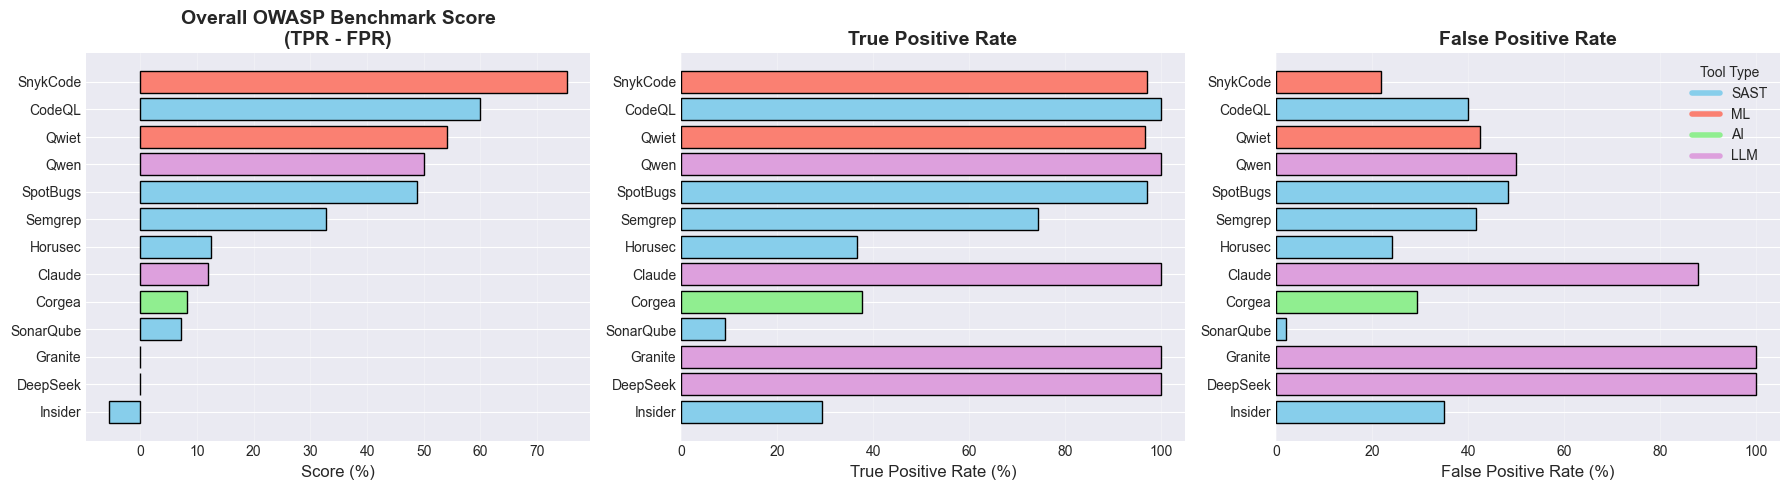

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# overall scores
df_summary_sorted = df_summary.sort_values('Score', ascending=True)
axes[0].barh(df_summary_sorted['Tool'], df_summary_sorted['Score'], color=df_summary_sorted['Type'].map(type_to_color), edgecolor='black')
axes[0].set_xlabel('Score (%)', fontsize=12)
axes[0].set_title('Overall OWASP Benchmark Score\n(TPR - FPR)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# TPR comparison
axes[1].barh(df_summary_sorted['Tool'], df_summary_sorted['TPR'], color=df_summary_sorted['Type'].map(type_to_color), edgecolor='black')
axes[1].set_xlabel('True Positive Rate (%)', fontsize=12)
axes[1].set_title('True Positive Rate', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# FPR comparison
axes[2].barh(df_summary_sorted['Tool'], df_summary_sorted['FPR'], color=df_summary_sorted['Type'].map(type_to_color), edgecolor='black')
axes[2].set_xlabel('False Positive Rate (%)', fontsize=12)
axes[2].set_title('False Positive Rate', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.legend(handles=[
    plt.Line2D([0], [0], color='skyblue', lw=4, label='SAST'),
    plt.Line2D([0], [0], color='salmon', lw=4, label='ML'),
    plt.Line2D([0], [0], color='lightgreen', lw=4, label='AI'),
    plt.Line2D([0], [0], color='plum', lw=4, label='LLM')
], title='Tool Type', loc='upper right')

plt.tight_layout()
plt.show()

### Performance Heatmap by Vulnerability Type

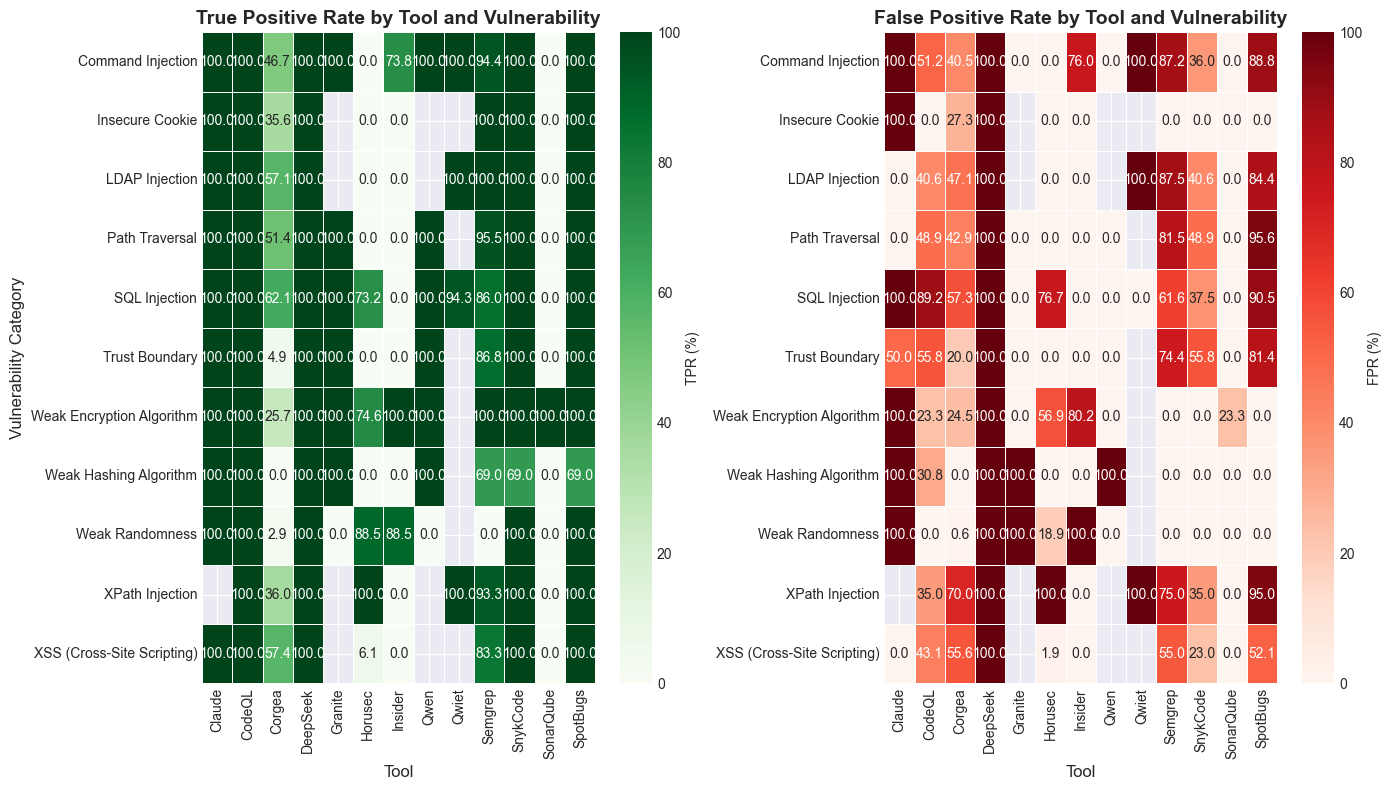

In [27]:
# pivot tables for heatmaps
pivot_tpr = df_tools.pivot(index='Category', columns='Tool', values='TPR')
pivot_fpr = df_tools.pivot(index='Category', columns='Tool', values='FPR')

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# TPR Heatmap
sns.heatmap(pivot_tpr, annot=True, fmt='.1f', cmap='Greens', ax=axes[0], 
            cbar_kws={'label': 'TPR (%)'}, linewidths=0.5, vmin=0, vmax=100)
axes[0].set_title('True Positive Rate by Tool and Vulnerability', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tool', fontsize=12)
axes[0].set_ylabel('Vulnerability Category', fontsize=12)

# FPR Heatmap
sns.heatmap(pivot_fpr, annot=True, fmt='.1f', cmap='Reds', ax=axes[1], 
            cbar_kws={'label': 'FPR (%)'}, linewidths=0.5, vmin=0, vmax=100)
axes[1].set_title('False Positive Rate by Tool and Vulnerability', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tool', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

### Score Heatmap

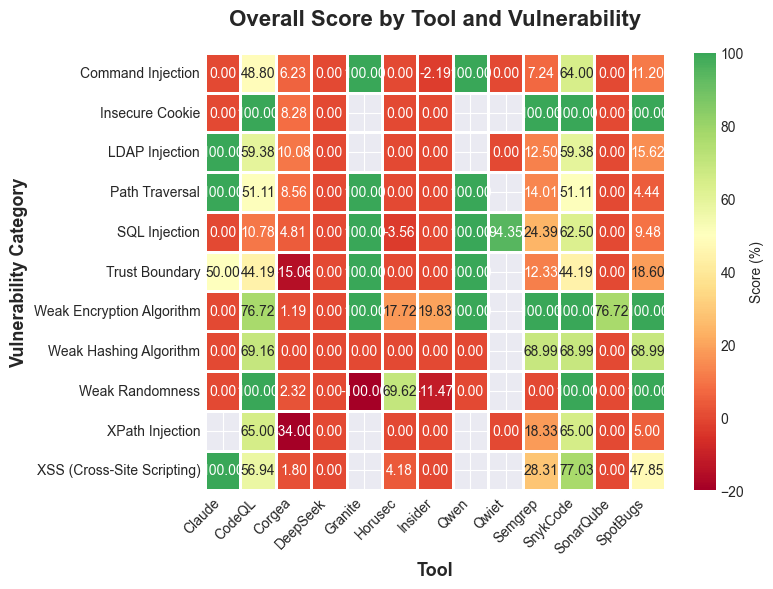

In [28]:
pivot_score = df_tools.pivot(index='Category', columns='Tool', values='Score')

plt.figure(figsize=(8, 6))

sns.heatmap(pivot_score, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score (%)'},
            linewidths=1, linecolor='white',
            center=50, vmin=-20, vmax=100)

plt.title('Overall Score by Tool and Vulnerability', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tool', fontsize=13, fontweight='bold')
plt.ylabel('Vulnerability Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### Performance by Vulnerability Type

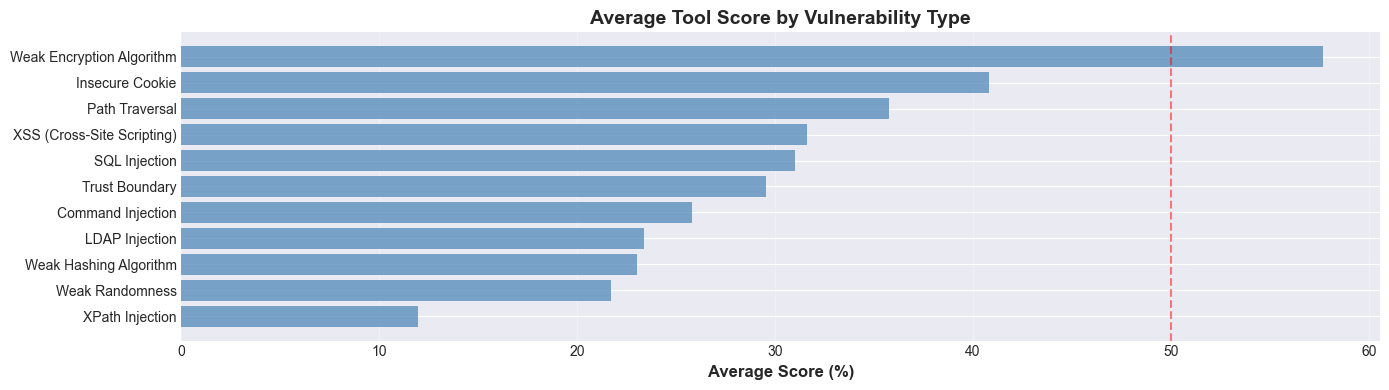

In [29]:
# calculate average performance per vulnerability
vuln_avg = df_tools.groupby('Category')[['TPR', 'FPR', 'Score']].mean().sort_values('Score', ascending=True)

fig, axes = plt.subplots(1, 1, figsize=(14,4))

# score by vulnerability
axes.barh(vuln_avg.index, vuln_avg['Score'], color='steelblue', alpha=0.7)
axes.set_xlabel('Average Score (%)', fontsize=12, fontweight='bold')
axes.set_title('Average Tool Score by Vulnerability Type', fontsize=14, fontweight='bold')
axes.grid(axis='x', alpha=0.3)
axes.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.show()

### Confusion Matrix

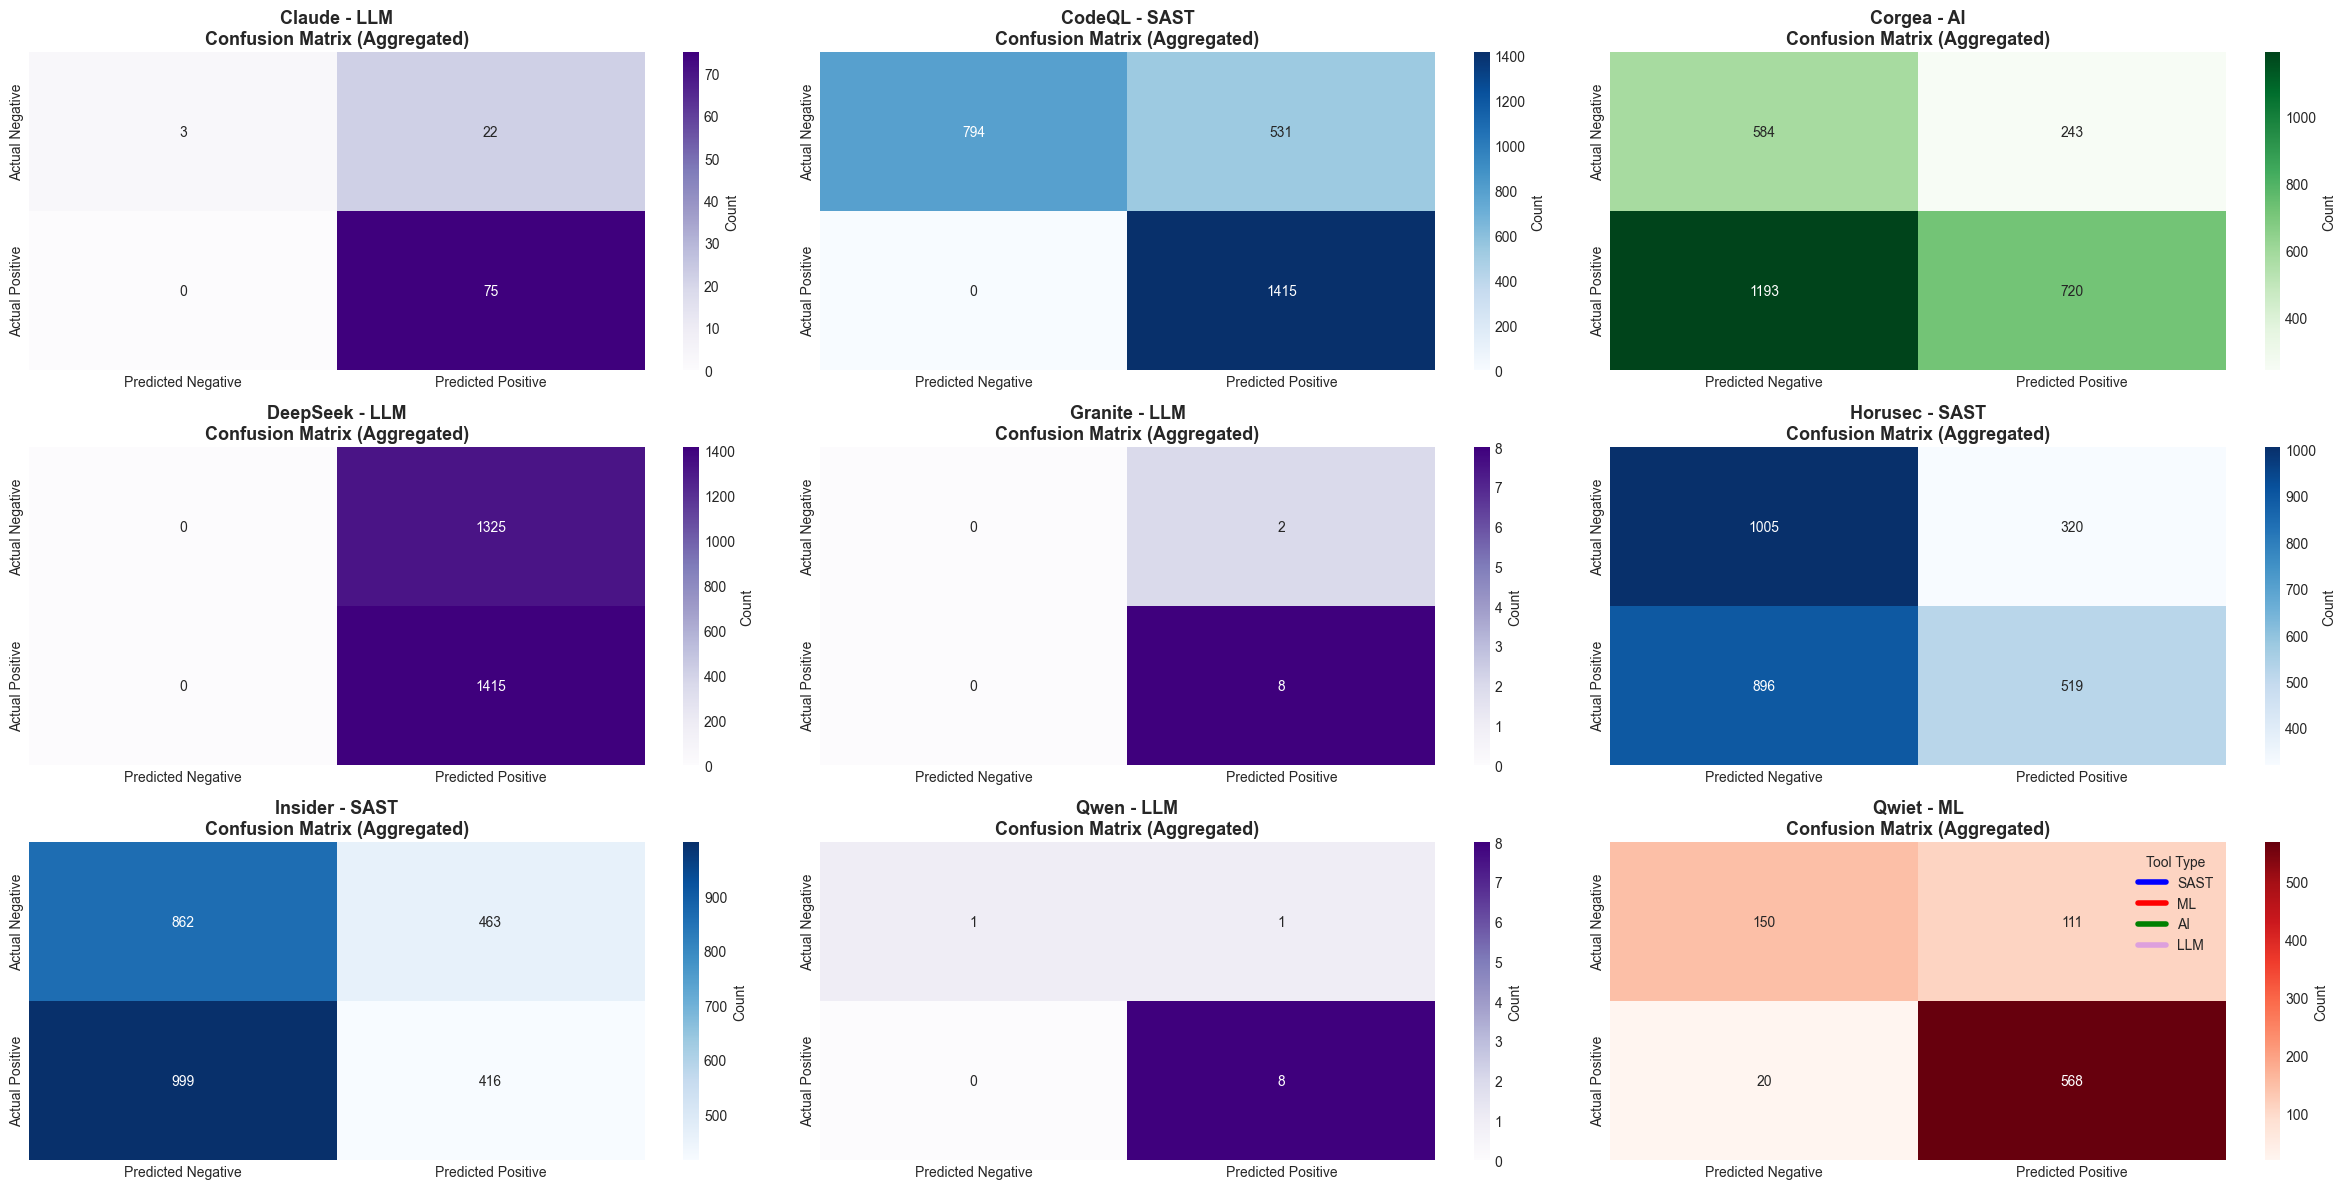

In [30]:
# aggregate confusion matrix values by tool
confusion_agg = df_tools.groupby('Tool')[['TP', 'FP', 'TN', 'FN']].sum()

fig, axes = plt.subplots(3, 3, figsize=(24, 12))
axes = axes.flatten()

tools = confusion_agg.index

for idx, tool in enumerate(tools):
    if idx < 9:
        type = df_tools['Type'].loc[df_tools['Tool']==tool].unique()[0]
        values = confusion_agg.loc[tool]
        
        cm = np.array([[values['TN'], values['FP']],
                        [values['FN'], values['TP']]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap=type_to_cmap[type], ax=axes[idx],
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'],
                    cbar_kws={'label': 'Count'})
        
        axes[idx].set_title(f'{tool} - {type}\nConfusion Matrix (Aggregated)', 
                            fontsize=13, fontweight='bold')

# hide unused subplots if less than 4 tools
for idx in range(len(tools), 4):
    axes[idx].set_visible(False)

plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='SAST'),
    plt.Line2D([0], [0], color='red', lw=4, label='ML'),
    plt.Line2D([0], [0], color='green', lw=4, label='AI'),
    plt.Line2D([0], [0], color='plum', lw=4, label='LLM')
], title='Tool Type', loc='upper right')

plt.tight_layout()
plt.show()

### Export Summary

In [31]:
# if 'df_tools' in locals():
#     # export complete dataset
#     df_tools.to_csv(os.path.join(to_save,'summary.csv'), index=False)
    
#     # Export pivot tables
#     pivot_tpr.to_csv(os.path.join(to_save,'tpr_by_tool_and_vulnerability.csv'))
#     pivot_fpr.to_csv(os.path.join(to_save,'fpr_by_tool_and_vulnerability.csv'))
#     pivot_score.to_csv(os.path.join(to_save,'score_by_tool_and_vulnerability.csv'))
    
#     # Export summary statistics
#     summary_stats.to_csv(os.path.join(to_save,'summary_statistics.csv'))
    
#     if 'df_summary' in locals() and df_summary is not None:
#         df_summary.to_csv(os.path.join(to_save,'overall_tool_scores.csv'), index=False)

## OWASP Benchmark vs Real-World CVE Comparison

Compare tool performance on synthetic OWASP Benchmark tests vs real-world CVE vulnerabilities

In [32]:
import json
from pathlib import Path

def load_realworld_results(results_dir='results/real_world'):
    """Load all real-world CVE test results"""
    results_dir = Path(results_dir)
    realworld_data = {}
    
    for json_file in results_dir.glob('*_test_results.json'):
        tool_name = json_file.stem.replace('_test_results', '')
        
        with open(json_file) as f:
            data = json.load(f)
            
        metrics = data.get('metrics', {})
        scenarios = metrics.get('scenarios', {})
        
        realworld_data[tool_name] = {
            'tool': tool_name,
            'total_cves': data.get('total_cves', 0),
            'sm_c_detected': scenarios.get('SM_C', {}).get('detected', 0),
            'sm_c_rate': scenarios.get('SM_C', {}).get('rate', 0),
            'sf_c_detected': scenarios.get('SF_C', {}).get('detected', 0),
            'sf_c_rate': scenarios.get('SF_C', {}).get('rate', 0),
            'sm_a_detected': scenarios.get('SM_A', {}).get('detected', 0),
            'sm_a_rate': scenarios.get('SM_A', {}).get('rate', 0),
            'sf_a_detected': scenarios.get('SF_A', {}).get('detected', 0),
            'sf_a_rate': scenarios.get('SF_A', {}).get('rate', 0),
            'false_positives': metrics.get('false_positives', 0),
            'cve_R_percent':metrics.get('CVE_R_percent', 0),
            'cve_Rpatch_percent': metrics.get('CVE_Rpatch_percent', 0),
            'avg_scan_time': metrics.get('avg_scan_time_seconds', 0),
        }
    
    return realworld_data

In [33]:
# Load real-world results
realworld_results = load_realworld_results()
print(f"Loaded real-world results for {len(realworld_results)} tools:")
for tool in realworld_results.keys():
    print(f"  - {tool}")

Loaded real-world results for 6 tools:
  - semgrep
  - sonarqube
  - insider
  - spotbugs
  - horusec
  - codeql


In [34]:
def create_comparison_df(owasp_df, realworld_results, comparison='sm_c_rate'):
    """
    Merge OWASP and Real-World results
    """
    comparison_data = []
    
    for tool in owasp_df['Tool'].unique():
        tool_lower = tool.lower()
        
        # Get OWASP metrics
        owasp_row = owasp_df[owasp_df['Tool'] == tool].iloc[0]
        
        # Get Real-World metrics (if available)
        rw = realworld_results.get(tool_lower, {})
        
        if rw:
            comparison_data.append({
                'Tool': tool,
                'Type': tool_types.get(tool, 'Unknown'),
                
                # OWASP Metrics
                'OWASP_TruePositive': owasp_row.get('TP', 0).get('sum', 0),
                'OWASP_FalsePositive': owasp_row.get('FP', 0).get('sum', 0),
                'OWASP_TrueNegative': owasp_row.get('TN', 0).get('sum', 0),
                'OWASP_FalseNegative': owasp_row.get('FN', 0).get('sum', 0),
                'OWASP_TPR': owasp_row.get('TPR', 0).get('mean', 0),
                'OWASP_Score': owasp_row.get('Score', 0).get('mean', 0),
                
                # Real-World Metrics
                'RW_Total_CVEs': rw.get('total_cves', 0),
                'RW_SM_C_Detected': rw.get('sm_c_detected', 0),
                'RW_SM_C_RATE': rw.get('sm_c_rate', 0),
                'RW_SM_A_Detected': rw.get('sm_a_detected', 0),
                'RW_SM_A_RATE': rw.get('sm_a_rate', 0),
                'RW_SF_C_Detected': rw.get('sf_c_detected', 0),
                'RW_SF_C_RATE': rw.get('sf_c_rate', 0),
                'RW_SF_A_Detected': rw.get('sf_a_detected', 0),
                'RW_SF_A_RATE': rw.get('sf_a_rate', 0),
                'RW_FalsePositives': rw.get('false_positives', 0),
                'RW_cve_R_Percent': rw.get('cve_R_percent', 0),
                'RW_cve_Rpatch_Percent': rw.get('cve_Rpatch_percent', 0),
                'RW_Avg_Scan_Time_Sec': rw.get('avg_scan_time', 0),
                
                # Calculated Gap
                'Performance_Gap': owasp_row.get('TPR', 0).get('mean', 0) - rw.get(comparison, 0),
            })
    
    return pd.DataFrame(comparison_data)

In [35]:
compare = 'sm_c_rate' # can be 'sm_c_rate' or 'sm_a_rate' etc.
comparison_df = create_comparison_df(summary_stats.reset_index(), realworld_results, comparison=compare)
comparison_df = comparison_df.sort_values('Performance_Gap', ascending=False)

print("OWASP vs Real-World Comparison:")
display(comparison_df[['Tool', 'Type', 'OWASP_TPR', f'RW_{compare.upper()}', 'Performance_Gap']])

OWASP vs Real-World Comparison:


,Tool,Type,OWASP_TPR,RW_SM_C_RATE,Performance_Gap
0,CodeQL,SAST,100.00,0.00,100.00
5,SpotBugs,SAST,97.18,0.00,97.18
3,Semgrep,SAST,82.58,0.61,81.97
1,Horusec,SAST,31.13,5.45,25.68
2,Insider,SAST,23.85,0.00,23.85
4,SonarQube,SAST,9.09,0.00,9.09


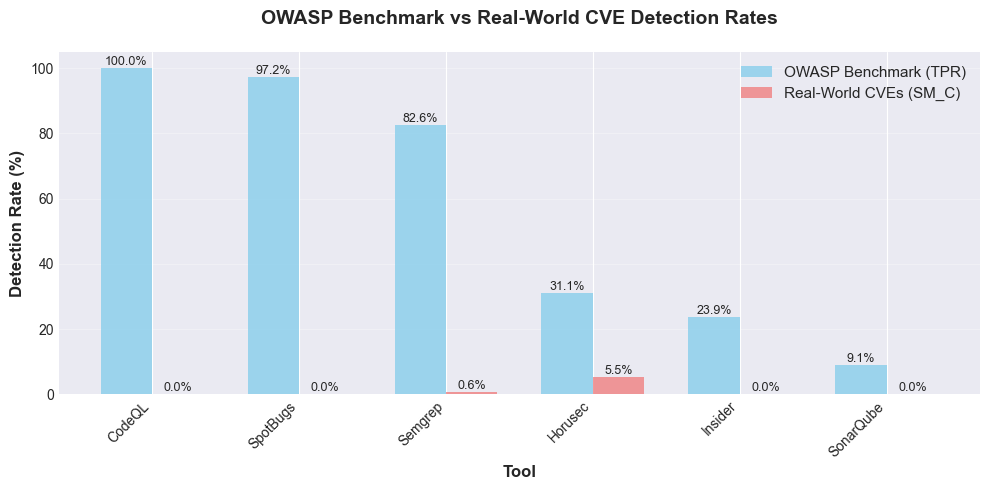

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

tools = comparison_df['Tool'].tolist()
owasp_rates = comparison_df['OWASP_TPR'].tolist()
rw_rates = comparison_df[f'RW_{compare.upper()}'].tolist()

x = np.arange(len(tools))
width = 0.35

bars1 = ax.bar(x - width/2, owasp_rates, width, label='OWASP Benchmark (TPR)', 
               color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, rw_rates, width, label=f'Real-World CVEs ({compare.upper()[:4]})', 
               color='lightcoral', alpha=0.8)

ax.set_xlabel('Tool', fontsize=12, fontweight='bold')
ax.set_ylabel('Detection Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('OWASP Benchmark vs Real-World CVE Detection Rates', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(tools, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

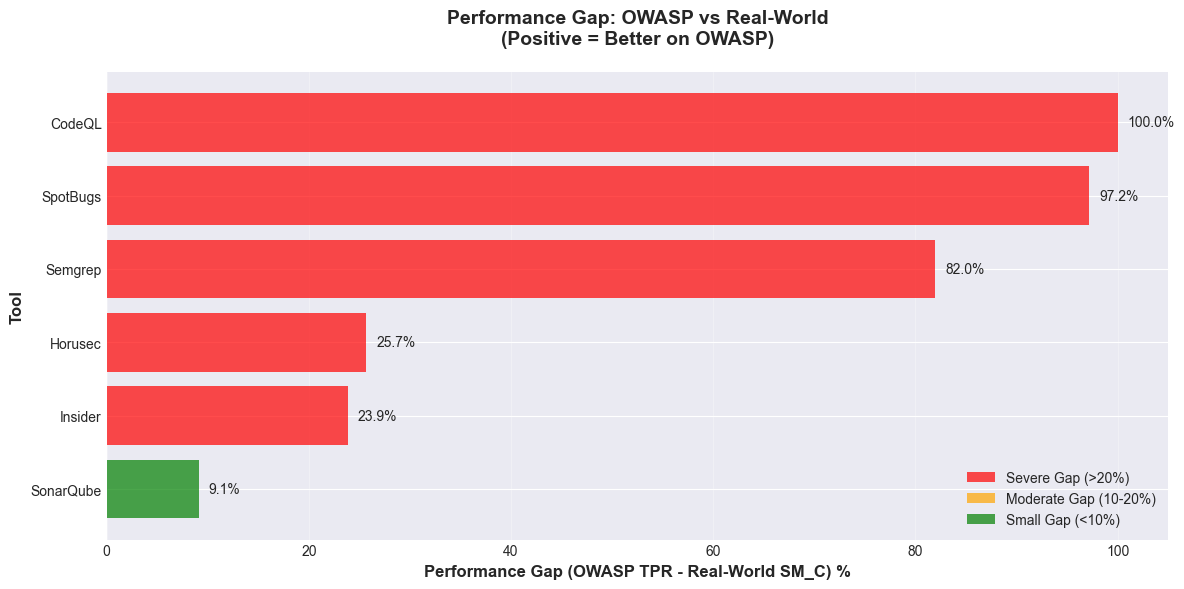

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by gap
gap_df = comparison_df.sort_values('Performance_Gap', ascending=True)

colors = ['red' if gap > 20 else 'orange' if gap > 10 else 'green' 
          for gap in gap_df['Performance_Gap']]

ax.barh(gap_df['Tool'], gap_df['Performance_Gap'], color=colors, alpha=0.7)
ax.set_xlabel(f'Performance Gap (OWASP TPR - Real-World {compare.upper()[:4]}) %', 
              fontsize=12, fontweight='bold')
ax.set_ylabel('Tool', fontsize=12, fontweight='bold')
ax.set_title(f'Performance Gap: OWASP vs Real-World\n(Positive = Better on OWASP)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (tool, gap) in enumerate(zip(gap_df['Tool'], gap_df['Performance_Gap'])):
    ax.text(gap + 1, i, f'{gap:.1f}%', va='center', fontsize=10)

legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='Severe Gap (>20%)'),
    Patch(facecolor='orange', alpha=0.7, label='Moderate Gap (10-20%)'),
    Patch(facecolor='green', alpha=0.7, label='Small Gap (<10%)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

In [38]:
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # Group by tool type
# type_comparison = comparison_df.groupby('Type').agg({
#     'OWASP_TPR': 'mean',
#     f'RW_{compare.upper()}': 'mean',
#     'Performance_Gap': 'mean'
# }).reset_index()

# # Plot 1: Detection rates by type
# ax = axes[0]
# x = np.arange(len(type_comparison))
# width = 0.35

# ax.bar(x - width/2, type_comparison['OWASP_TPR'], width, 
#        label='OWASP', color='skyblue', alpha=0.8)
# ax.bar(x + width/2, type_comparison[f'RW_{compare.upper()}'], width, 
#        label='Real-World', color='lightcoral', alpha=0.8)

# ax.set_xlabel('Tool Type', fontsize=12, fontweight='bold')
# ax.set_ylabel('Average Detection Rate (%)', fontsize=12, fontweight='bold')
# ax.set_title(f'Average Detection Rate by Tool Type ({compare.upper()[:4]})', fontsize=13, fontweight='bold')
# ax.set_xticks(x)
# ax.set_xticklabels(type_comparison['Type'])
# ax.legend()
# ax.grid(axis='y', alpha=0.3)

# # Plot 2: Gap by type
# ax = axes[1]
# colors = ['skyblue', 'lightgreen', 'plum'] # SAST, ML, AI
# ax.bar(type_comparison['Type'], type_comparison['Performance_Gap'], 
#        color=colors, alpha=0.7)

# ax.set_xlabel('Tool Type', fontsize=12, fontweight='bold')
# ax.set_ylabel('Average Performance Gap (%)', fontsize=12, fontweight='bold')
# ax.set_title(f'Performance Gap by Tool Type ({compare.upper()[:4]})', fontsize=13, fontweight='bold')
# ax.grid(axis='y', alpha=0.3)

# for i, (t, gap) in enumerate(zip(type_comparison['Type'], type_comparison['Performance_Gap'])):
#     ax.text(i, gap + 1, f'{gap:.1f}%', ha='center', fontsize=11, fontweight='bold')

# plt.tight_layout()
# plt.show()

# print("\nAverage Performance by Tool Type:")
# print(type_comparison.to_string(index=False))



In [39]:
# comparison_df.to_csv('owasp_vs_realworld_comparison.csv', index=False)
# print("\nSaved: owasp_vs_realworld_comparison.csv")

# # Create summary report
# summary = {
#     'total_tools_compared': len(comparison_df),
#     'owasp_avg_tpr': float(comparison_df['OWASP_TPR'].mean()),
#     'realworld_avg_sm_c': float(comparison_df['RW_SM_C_Rate'].mean()),
#     'avg_performance_gap': float(comparison_df['Performance_Gap'].mean())
# }

# with open('comparison_summary.json', 'w') as f:
#     json.dump(summary, f, indent=2)

# print("Saved: comparison_summary.json")

## Comparison with Paper's Published Results

In [40]:
# Correct Real-World CVE Results from Paper
paper_realworld_results = {
    'horusec': {
        'SF_A': 57,
        'SF_C': 38,
        'SM_A': 46,
        'SM_C': 28,
        'Manual_Check': 21,
        'total': 165,
        'sm_c_rate': (21/165)*100,
        'false_positives': 6,
        'fp_rate': (6/21)*100,
    },
    'spotbugs': {
        'SF_A': 34,
        'SF_C': 26,
        'SM_A': 31,
        'SM_C': 19,
        'Manual_Check': 17,
        'total': 165,
        'sm_c_rate': (17/165)*100,
        'false_positives': 16,
        'fp_rate': (16/17)*100,
    },
    'codeql': {
        'SF_A': 24,
        'SF_C': 15,
        'SM_A': 20,
        'SM_C': 13,
        'Manual_Check': 11,
        'total': 165,
        'sm_c_rate': (11/165)*100,
        'false_positives': 5,
        'fp_rate': (5/11)*100,
    },
    'semgrep': {
        'SF_A': 60,
        'SF_C': 31,
        'SM_A': 37,
        'SM_C': 17,
        'Manual_Check': 9,
        'total': 165,
        'sm_c_rate': (9/165)*100,
        'false_positives': 4,
        'fp_rate': (4/9)*100,
    },
    'sonarqube': {
        'SF_A': 22,
        'SF_C': 12,
        'SM_A': 16,
        'SM_C': 10,
        'Manual_Check': 9,
        'total': 165,
        'sm_c_rate': (9/165)*100,
        'false_positives': 5,
        'fp_rate': (5/9)*100,
    },
    'insider': {
        'SF_A': 29,
        'SF_C': 11,
        'SM_A': 19,
        'SM_C': 9,
        'Manual_Check': 4,
        'total': 165,
        'sm_c_rate': (4/165)*100,
        'false_positives': 4,
        'fp_rate': (4/4)*100,
    },
    # 'contrast': {
    #     'SF_A': 3,
    #     'SF_C': 2,
    #     'SM_A': 2,
    #     'SM_C': 1,
    #     'Manual_Check': 1,
    #     'total': 165,
    #     'sm_c_rate': (1/165)*100,
    #     'false_positives': 1,
    #     'fp_rate': (1/1)*100,
    # },
}

In [41]:
paper_owasp_results = {
    'semgrep': {'recall': 90.0, 'precision': 70.0, 'f1-score': 79.8},
    'horusec': {'recall': 30.0, 'precision': 28.0, 'f1-score': 29.7},
    'codeql': {'recall': 70.0, 'precision': 38.0, 'f1-score': 49.0},
    'spotbugs': {'recall': 97.0, 'precision': 71.0, 'f1-score': 82.8},
    'sonarqube': {'recall': 37.0, 'precision': 22.0, 'f1-score': 27.0},
    'insider': {'recall': 24.0, 'precision': 8.0, 'f1-score': 13.9},
    'contrast': {'recall': 94.0, 'precision': 77.0, 'f1-score': 84.4},
}

In [42]:
def create_paper_comparison(our_results, paper_rw_results, paper_owasp_results):
    """Compare our replication with paper's results"""
    comparison_data = []
    
    for tool in paper_rw_results.keys():
        # Paper's results
        paper_rw = paper_rw_results[tool]
        paper_owasp = paper_owasp_results[tool]
        
        # Our results
        our_rw = our_results.get(tool, {})
        
        summary_stats_indexed = summary_stats.reset_index()

        comparison_data.append({
            'Tool': tool.upper(),
            
            # Paper's Real-World Results
            'Paper_RW_SM_C': f"{paper_rw['Manual_Check']}/{paper_rw['total']} ({paper_rw['sm_c_rate']:.1f}%)",
            'Paper_RW_SM_C_Rate': paper_rw['sm_c_rate'],
            
            'Paper_RW_SM_A': f"{paper_rw['SM_A']}/{paper_rw['total']} ({(paper_rw['SM_A']/paper_rw['total']*100):.1f}%)",
            'Paper_RW_SM_A_Rate': (paper_rw['SM_A']/paper_rw['total']*100),

            # Our Real-World Results
            'Our_RW_SM_C': f"{our_rw.get('sm_c_detected', '?')}/{our_rw.get('total_cves', '?')}" + 
                          (f" ({our_rw.get('sm_c_rate', 0):.1f}%)" if our_rw else ''),
            'Our_RW_SM_C_Rate': our_rw.get('sm_c_rate', None),
            
            'Our_RW_SM_A': f"{our_rw.get('sm_a_detected', '?')}/{our_rw.get('total_cves', '?')}" + 
                          (f" ({our_rw.get('sm_a_rate', 0):.1f}%)" if our_rw else ''),
            'Our_RW_SM_A_Rate': our_rw.get('sm_a_rate', None),
            
            # Difference
            'RW_SM_C_Difference': (our_rw.get('sm_c_rate', 0) - paper_rw['sm_c_rate']) if our_rw else None,
            'RW_SM_A_Difference': (our_rw.get('sm_a_rate', 0) - (paper_rw['SM_A']/paper_rw['total']*100)) if our_rw else None,
            
            # Paper's OWASP Results
            'Paper_OWASP_Recall': f"{paper_owasp.get('recall', None)}",
            'Paper_OWASP_Precision': paper_owasp.get('precision', None),
            'Paper_OWASP_F1': paper_owasp.get('f1-score', None),
            
            # Our OWASP Results
            'Our_OWASP_Recall': f"{summary_stats_indexed.loc[summary_stats_indexed['Tool'].str.lower() == tool.lower()]['Recall'].values[0]:.1f}%" if not summary_stats_indexed.loc[summary_stats_indexed['Tool'].str.lower() == tool.lower()].empty else '?',
            'Our_OWASP_Precision': f"{summary_stats_indexed.loc[summary_stats_indexed['Tool'].str.lower() == tool.lower()]['Precision'].values[0]}" if not summary_stats_indexed.loc[summary_stats_indexed['Tool'].str.lower() == tool.lower()].empty else '?',
            'Our_OWASP_F1': f"{summary_stats_indexed.loc[summary_stats_indexed['Tool'].str.lower() == tool.lower()]['F1-Score'].values[0]:.1f}" if not summary_stats_indexed.loc[summary_stats_indexed['Tool'].str.lower() == tool.lower()].empty else '?',

            # Gap (Paper's calculation)
            'Paper_Gap': paper_owasp.get('TPR', 0) - paper_rw['sm_c_rate'] if paper_owasp else None,
        })
    
    return pd.DataFrame(comparison_data)

In [43]:
paper_comparison_df = create_paper_comparison(
    realworld_results,
    paper_realworld_results, 
    paper_owasp_results
)

In [44]:
print("Our Replication vs Paper's Published Results:\n")
display(paper_comparison_df[['Tool', 'Paper_RW_SM_C', 'Our_RW_SM_C', 'Paper_RW_SM_A', 'Our_RW_SM_A', 'Paper_OWASP_F1', 'Our_OWASP_F1']])

Our Replication vs Paper's Published Results:



,Tool,Paper_RW_SM_C,Our_RW_SM_C,Paper_RW_SM_A,Our_RW_SM_A,Paper_OWASP_F1,Our_OWASP_F1
0,HORUSEC,21/165 (12.7%),9/165 (5.5%),46/165 (27.9%),28/165 (17.0%),29.7,46.0
1,SPOTBUGS,17/165 (10.3%),0/165 (0.0%),31/165 (18.8%),0/165 (0.0%),82.8,80.2
2,CODEQL,11/165 (6.7%),0/165 (0.0%),20/165 (12.1%),7/165 (4.2%),49.0,84.2
3,SEMGREP,9/165 (5.5%),1/165 (0.6%),37/165 (22.4%),8/165 (4.8%),79.8,69.7
4,SONARQUBE,9/165 (5.5%),0/165 (0.0%),16/165 (9.7%),0/165 (0.0%),27.0,16.5
5,INSIDER,4/165 (2.4%),0/165 (0.0%),19/165 (11.5%),0/165 (0.0%),13.9,36.3


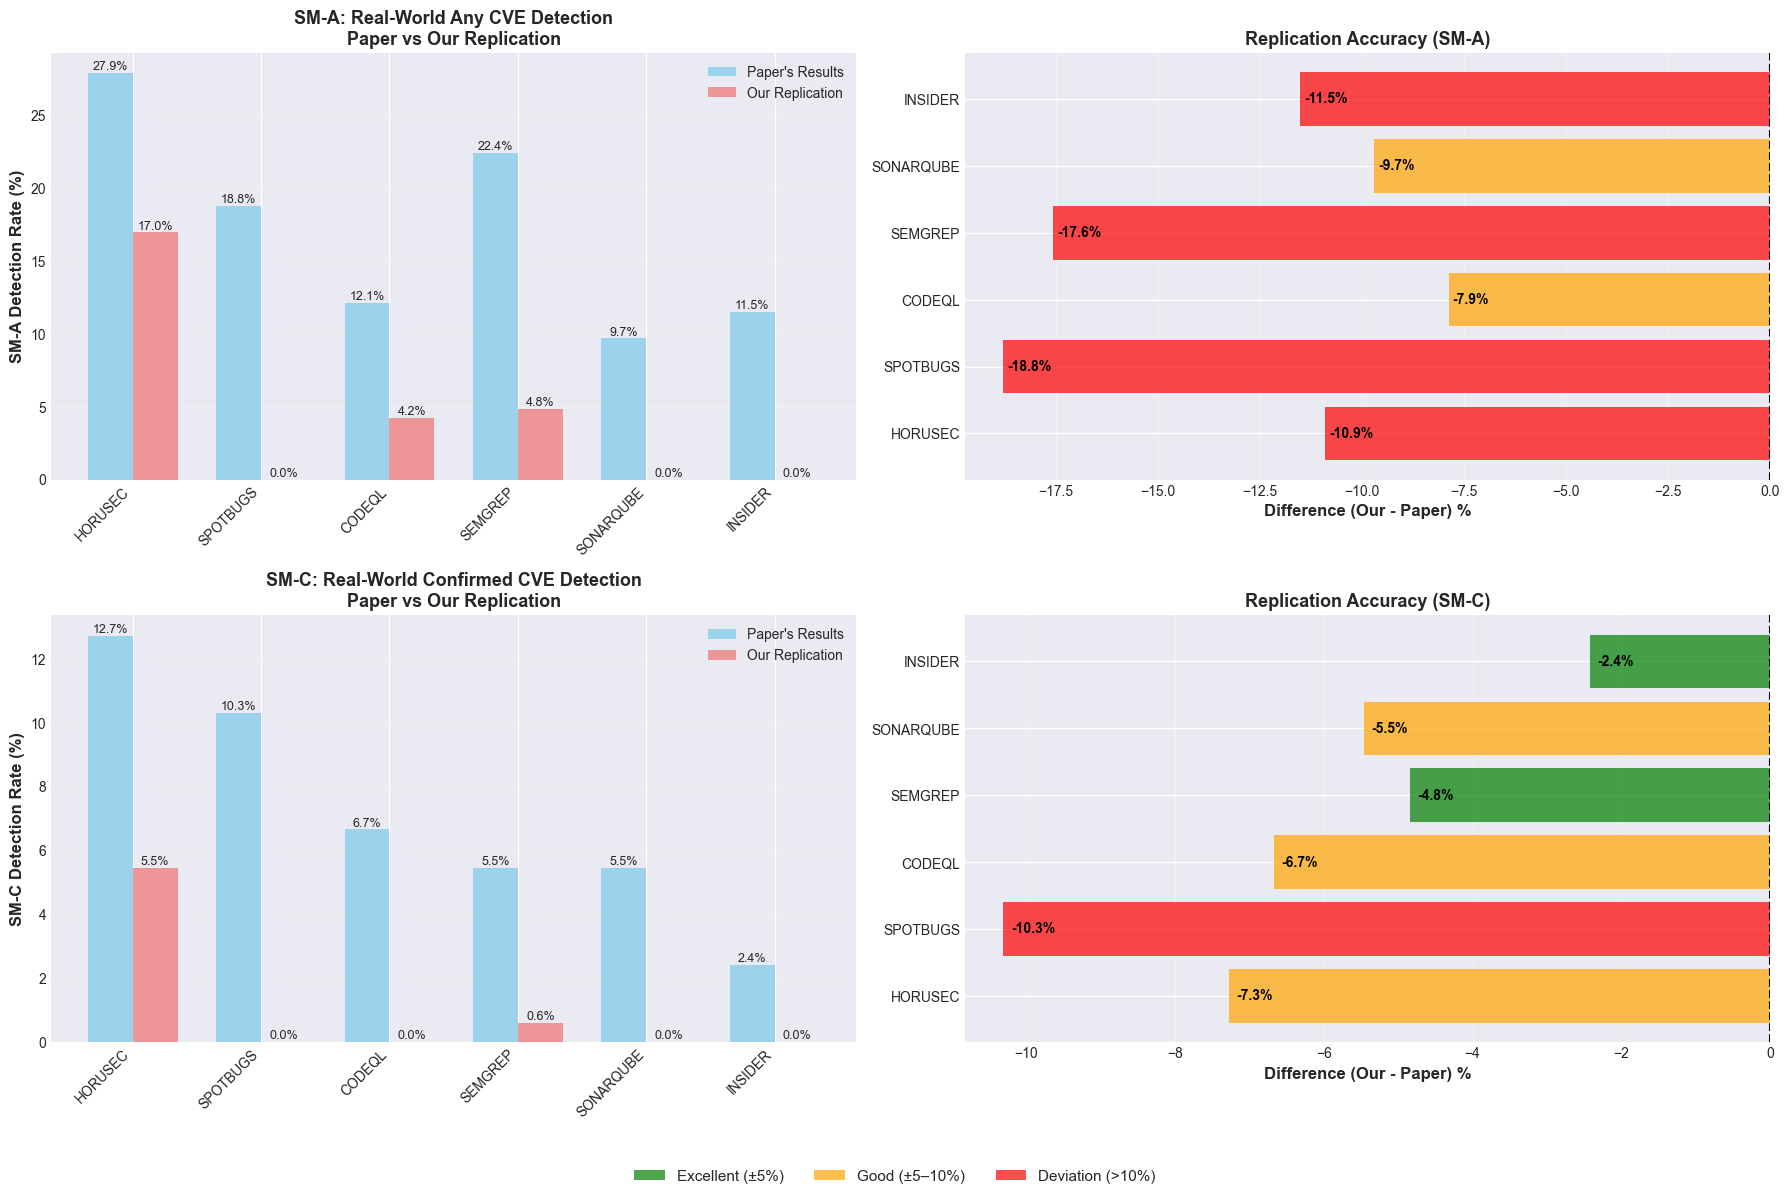

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
(ax1_a, ax2_a), (ax1_c, ax2_c) = axes

# SM-A (TOP)

tested_a = paper_comparison_df[
    paper_comparison_df['Our_RW_SM_A_Rate'].notna()
].copy()

if len(tested_a) > 0:
    tools = tested_a['Tool'].tolist()
    paper_rates = tested_a['Paper_RW_SM_A_Rate'].tolist()
    our_rates = tested_a['Our_RW_SM_A_Rate'].tolist()
    differences = tested_a['RW_SM_A_Difference'].tolist()

    x = np.arange(len(tools))
    width = 0.35

    bars1 = ax1_a.bar(x - width/2, paper_rates, width,
                      label="Paper's Results", color='skyblue', alpha=0.8)
    bars2 = ax1_a.bar(x + width/2, our_rates, width,
                      label='Our Replication', color='lightcoral', alpha=0.8)

    ax1_a.set_ylabel('SM-A Detection Rate (%)', fontsize=12, fontweight='bold')
    ax1_a.set_title(
        'SM-A: Real-World Any CVE Detection\nPaper vs Our Replication',
        fontsize=13, fontweight='bold'
    )
    ax1_a.set_xticks(x)
    ax1_a.set_xticklabels(tools, rotation=45, ha='right')
    ax1_a.legend()
    ax1_a.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            ax1_a.text(bar.get_x() + bar.get_width()/2, h,
                       f'{h:.1f}%', ha='center', va='bottom', fontsize=9)

    colors = ['green' if abs(d) < 5 else 'orange' if abs(d) < 10 else 'red'
              for d in differences]

    ax2_a.barh(tools, differences, color=colors, alpha=0.7)
    ax2_a.axvline(0, color='black', linestyle='--')
    ax2_a.set_xlabel('Difference (Our - Paper) %', fontsize=12, fontweight='bold')
    ax2_a.set_title('Replication Accuracy (SM-A)', fontsize=13, fontweight='bold')
    ax2_a.grid(axis='x', alpha=0.3)

    for i, diff in enumerate(differences):
        if round(diff) > 0:
            x_pos = diff - 0.05
            ha = 'right'
        elif round(diff) < 0:
            x_pos = diff + 0.1
            ha = 'left'
        else:
            x_pos = diff + 0.05
            ha = 'left'

        ax2_a.text(
            x_pos, i, f'{diff:+.1f}%',
            va='center', ha=ha, color='black',
            fontsize=10, fontweight='bold'
        )


# SM-C (BOTTOM)

tested_c = paper_comparison_df[
    paper_comparison_df['Our_RW_SM_C_Rate'].notna()
].copy()

if len(tested_c) > 0:
    tools = tested_c['Tool'].tolist()
    paper_rates = tested_c['Paper_RW_SM_C_Rate'].tolist()
    our_rates = tested_c['Our_RW_SM_C_Rate'].tolist()
    differences = tested_c['RW_SM_C_Difference'].tolist()

    x = np.arange(len(tools))

    bars1 = ax1_c.bar(x - width/2, paper_rates, width,
                      label="Paper's Results", color='skyblue', alpha=0.8)
    bars2 = ax1_c.bar(x + width/2, our_rates, width,
                      label='Our Replication', color='lightcoral', alpha=0.8)

    ax1_c.set_ylabel('SM-C Detection Rate (%)', fontsize=12, fontweight='bold')
    ax1_c.set_title(
        'SM-C: Real-World Confirmed CVE Detection\nPaper vs Our Replication',
        fontsize=13, fontweight='bold'
    )
    ax1_c.set_xticks(x)
    ax1_c.set_xticklabels(tools, rotation=45, ha='right')
    ax1_c.legend()
    ax1_c.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            ax1_c.text(bar.get_x() + bar.get_width()/2, h,
                       f'{h:.1f}%', ha='center', va='bottom', fontsize=9)

    colors = ['green' if abs(d) < 5 else 'orange' if abs(d) < 10 else 'red'
              for d in differences]

    ax2_c.barh(tools, differences, color=colors, alpha=0.7)
    ax2_c.axvline(0, color='black', linestyle='--')
    ax2_c.set_xlabel('Difference (Our - Paper) %', fontsize=12, fontweight='bold')
    ax2_c.set_title('Replication Accuracy (SM-C)', fontsize=13, fontweight='bold')
    ax2_c.grid(axis='x', alpha=0.3)

    for i, diff in enumerate(differences):
        if round(diff) > 0:
            x_pos = diff - 0.05
            ha = 'right'
        elif round(diff) < 0:
            x_pos = diff + 0.1
            ha = 'left'
        else:
            x_pos = diff + 0.05
            ha = 'left'

        ax2_c.text(
            x_pos, i, f'{diff:+.1f}%',
            va='center', ha=ha, color='black',
            fontsize=10, fontweight='bold'
        )

# Legend (Shared)

legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Excellent (±5%)'),
    Patch(facecolor='orange', alpha=0.7, label='Good (±5–10%)'),
    Patch(facecolor='red', alpha=0.7, label='Deviation (>10%)')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [46]:
def create_false_positive_table(paper_results_list, tool_results_list):
    """
    Create false positive comparison table.
    """
    table_data = []
    
    for result in tool_results_list:
        tool_name = result['tool']
        
        # Extract SM_C data  
        paper_sm_c_detected = paper_results_list[tool_name]['Manual_Check']
        sm_c_detected = result['sm_c_detected']
        
        # Get false positives
        paper_fp_count = paper_results_list[tool_name]['false_positives']
        fp_count = result['false_positives']
                
        table_data.append({
            ('Tools', ''): tool_name,
            ('Paper', '# D_{Vul}'): paper_sm_c_detected,
            ('Paper', '# (D_{vul} ∩ D_{patch})'): paper_fp_count,
            ('Our Replication', '# D_{Vul}'): sm_c_detected,
            ('Our Replication', '# (D_{vul} ∩ D_{patch})'): fp_count
        })

    df = pd.DataFrame(table_data)
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    
    # Sort by tool name or by SM_C_DVul descending
    df = df.sort_values(['Tools'], ascending=True).reset_index(drop=True)
    
    return df

In [47]:
# paper_realworld_results
# realworld_results

In [48]:
df = create_false_positive_table(paper_realworld_results, realworld_results.values())
df

Tools     Paper                         Our Replication  \
             # D_{Vul} # (D_{vul} ∩ D_{patch})       # D_{Vul}   
0     codeql        11                       5               0   
1    horusec        21                       6               9   
2    insider         4                       4               0   
3    semgrep         9                       4               1   
4  sonarqube         9                       5               0   
5   spotbugs        17                      16               0   

                           
  # (D_{vul} ∩ D_{patch})  
0                       0  
1                       7  
2                       0  
3                       0  
4                       0  
5                       0